# install dependencies

In [ ]:
!pip install diffusers datasets torchmetrics ftfy regex tqdm git+https://github.com/openai/CLIP.git pytorch-lightning transformers accelerate peft


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0kjgn_4r
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0kjgn_4r
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
import diffusers
diffusers.logging.set_verbosity_warning()

diffusers.logging.disable_progress_bar()
import datasets
datasets.disable_progress_bar()


# Load Data

In [ ]:
 # dont need to run anymore
 !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: Traceback (most recent call last):
  File "/usr/lib/python3.10/getpass.py", line 77, in unix_getpass
    passwd = _raw_input(prompt, stream, input=input)
  File "/usr/lib/python3.10/getpass.py", line 146, in _raw_input
    line = input.readline()
KeyboardInterrupt

During handling of the above exception, another e

In [ ]:
# randomly sample 1000 captions from coco caption benchmark
# dont run this again it takes forever

# TODO: improvement take random 1000 samples
from datasets import load_dataset

dataset = load_dataset("HuggingFaceM4/COCO", split='test[0:10]',trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset = dataset.shuffle(seed=42)

In [ ]:
# check that it is 1000 samples

dataset.shape

In [ ]:
#input: datset
def parseRelevantFromDataset(input):
  prompts = []
  images = []
  for row in input:
    prompt = row['sentences']['raw']
    prompts.append(prompt)
    images.append(row['image'])
  return prompts, images


In [ ]:
prompts, images = parseRelevantFromDataset(dataset)

# EDA for images (TODO)

In [ ]:
# TODO: check distribution size of images in coco

# Clip Score Function

In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial
### dont move to another cell
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)
### dont move to another cell

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# SDXL Model definintion

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

sd_pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

# prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
# image = sd_pipeline(prompt=prompt).images[0]
# image

In [ ]:
# avg clip score: 35.34
# avg imag reward
# aesthetic score:

# image reward
# -------iteration  0
# image reward for V1-4: 1.535229206085205
# avg image reward for V1-4: 1.535229206085205

In [ ]:
from daam import trace, set_seed
# from diffusers import DiffusionPipeline
from matplotlib import pyplot as plt
import torch


model_id = 'stabilityai/stable-diffusion-xl-base-1.0'
device = 'cuda'

# pipe = DiffusionPipeline.from_pretrained(model_id, use_auth_token=True, torch_dtype=torch.float16, use_safetensors=True, variant='fp16')
# pipe = pipe.to(device)

prompt = 'A dog runs across the field'
gen = set_seed(0)  # for reproducibility

with torch.no_grad():
    with trace(pipe) as tc:
        out = sd_pipeline(prompt, num_inference_steps=50, generator=gen)
        heat_map = tc.compute_global_heat_map()
        heat_map = heat_map.compute_word_heat_map('dog')
        heat_map.plot_overlay(out.images[0])
        plt.show()

#  Stable Diffusion V1-4 (LDM) - ClipScore (DONE)
https://huggingface.co/docs/diffusers/en/conceptual/evaluation

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_ckpt = "CompVis/stable-diffusion-v1-4"
sd_pipeline = StableDiffusionPipeline.from_pretrained(model_ckpt, torch_dtype=torch.float16).to("cuda")

In [ ]:
# Example row
# images are 640x360
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
 'filepath': 'COCO_val2014_000000391895.jpg',
 'sentids': [770337, 771687, 772707, 776154, 781998],
 'filename': 'COCO_val2014_000000391895.jpg',
 'imgid': 0,
 'split': 'test',
 'sentences': {'tokens': ['a',
   'man',
   'with',
   'a',
   'red',
   'helmet',
   'on',
   'a',
   'small',
   'moped',
   'on',
   'a',
   'dirt',
   'road'],
  'raw': 'A man with a red helmet on a small moped on a dirt road. ',
  'imgid': 0,
  'sentid': 770337},
 'cocoid': 391895}

In [ ]:
dataset[0]['sentences']['raw']

'A man with a red helmet on a small moped on a dirt road. '

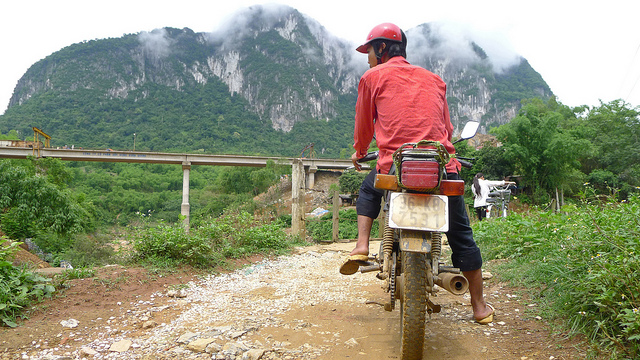

In [ ]:
dataset[0]['image']

In [ ]:
sd_pipeline.safety_checker = None

num_inference_steps = 75
# higher inf step == higher clip score?


v14Image_total_clip_score = 0
# i = 0
for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]
  # cocoNpImage = pilJpgImageToNp(image)

  v14Image = sd_pipeline(disable_tqdm = True,prompt=prompt,num_images_per_prompt=1, num_inference_steps=num_inference_steps, guidance_scale=8.0, output_type='np' ).images
  sd_pipeline.set_progress_bar_config(disable=True)
  # print('sdxl image shape:',sdxlImage.shape) #  (1, 512, 512, 3)
  # print('cocoNpImage image shape:',cocoNpImage.shape) #(1, 360, 640, 3)

  # disable_tqdm=True

  v14_clip_score = calculate_clip_score(v14Image, prompt)
  # coco_clip_score = calculate_clip_score(cocoNpImage, prompt)

  v14Image_total_clip_score += v14_clip_score
  # total_clip_score += img_clip_score
  # if i % 10 == 0:
  print("-------iteration ", i)
  print('clip score for V1-4:', v14_clip_score)
  print('avg clip score for V1-4:', v14Image_total_clip_score/(i+1))





# clip score:
v14Image_total_clip_score = v14Image_total_clip_score/dataset.shape[0]
print('V1-4 clip score:', v14_clip_score)
# -------iteration  0
# clip score for V1-4: 33.5599
# avg clip score for V1-4: 33.5599
# -------iteration  100
# clip score for V1-4: 32.7831
# avg clip score for V1-4: 31.407696039603973
# -------iteration  200
# clip score for V1-4: 33.9116
# avg clip score for V1-4: 31.900802985074623
# -------iteration  300
# clip score for V1-4: 36.8707
# avg clip score for V1-4: 32.0721518272425
# -------iteration  400
# clip score for V1-4: 32.0595
# avg clip score for V1-4: 32.205682294264314
# -------iteration  500
# clip score for V1-4: 28.5269
# avg clip score for V1-4: 32.11141656686625
# -------iteration  600
# clip score for V1-4: 31.7294
# avg clip score for V1-4: 31.98278119800331
# -------iteration  700
# clip score for V1-4: 33.7691
# avg clip score for V1-4: 31.8385139800285
# -------iteration  800
# clip score for V1-4: 34.9334
# avg clip score for V1-4: 31.768774906367028
# -------iteration  900
# clip score for V1-4: 29.2342
# avg clip score for V1-4: 31.721726082130942
# V1-4 clip score: 34.3325


-------iteration  0
clip score for V1-4: 35.34
avg clip score for V1-4: 35.34
V1-4 clip score: 30.9215


# Stable Diffusion V1-4 Image Reward (DONE)

In [ ]:
# https://huggingface.co/THUDM/ImageReward


In [ ]:
!pip install image-reward

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 31.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332108 sha256=0fef15c359af357ab242127853ba83ef418a62c3f57b1bdedc37417866ef07b2
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898f76e58ec421b88e8cb3
Successfully built fairscale


In [ ]:
sd_pipeline.safety_checker = None

num_inference_steps = 70
# higher inf step == higher clip score?


v14Image_total_image_reward = 0

import os
import torch
import ImageReward as reward


for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]
  # cocoNpImage = pilJpgImageToNp(image)

  v14Image = sd_pipeline(disable_tqdm = True,prompt=prompt,num_images_per_prompt=1, num_inference_steps=num_inference_steps, guidance_scale=8.0).images[0]
  # type(v14Image)
  sd_pipeline.set_progress_bar_config(disable=True)
  # print('sdxl image shape:',sdxlImage.shape) #  (1, 512, 512, 3)
  # print('cocoNpImage image shape:',cocoNpImage.shape) #(1, 360, 640, 3)

  # disable_tqdm=True
  imageReward = reward.load("ImageReward-v1.0")
  with torch.no_grad():
    v14_image_reward = imageReward.score(prompt, v14Image)

  v14Image_total_image_reward += v14_image_reward
  # total_clip_score += img_clip_score
  if i % 10 == 0:
    print("-------iteration ", i)
    print('image reward for V1-4:', v14_image_reward)
    print('avg image reward for V1-4:', v14Image_total_image_reward/(i+1))

    # -------iteration  0
# image reward for V1-4: 1.6850208044052124
# avg image reward for V1-4: 1.6850208044052124


# -------iteration  100
# image reward for V1-4: 0.7650266289710999
# avg image reward for V1-4: 0.15076378142774696


load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
-------iteration  0
image reward for V1-4: 1.535229206085205
avg image reward for V1-4: 1.535229206085205
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded


# Stable Diffusion V1-4 Improved Aesthetic Predictor (DONE)

In [ ]:
# https://github.com/christophschuhmann/improved-aesthetic-predictor

In [ ]:
import webdataset as wds
from PIL import Image
import io
import matplotlib.pyplot as plt
import os
import json

from warnings import filterwarnings


# os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # choose GPU if you are on a multi GPU server
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torchvision import datasets, transforms
import tqdm

from os.path import join
from datasets import load_dataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import json

import clip


from PIL import Image, ImageFile


#####  This script will predict the aesthetic score for this image file:

img_path = "test.jpg"





# if you changed the MLP architecture during training, change it also here:
class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 16),
            #nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
            x = batch[self.xcol]
            y = batch[self.ycol].reshape(-1, 1)
            x_hat = self.layers(x)
            loss = F.mse_loss(x_hat, y)
            return loss

    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def normalized(a, axis=-1, order=2):
    import numpy as np  # pylint: disable=import-outside-toplevel

    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)


In [ ]:
aestheticPredictorModel = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14

s = torch.load("sac+logos+ava1-l14-linearMSE.pth")   # load the model you trained previously or the model available in this repo

aestheticPredictorModel.load_state_dict(s)

aestheticPredictorModel.to("cuda")
aestheticPredictorModel.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model2, preprocess = clip.load("ViT-L/14", device=device)  #RN50x64


In [ ]:

pil_image = images[0] # can be pil image or img path
image = preprocess(pil_image).unsqueeze(0).to(device)


sd_pipeline.safety_checker = None

num_inference_steps = 70
# higher inf step == higher clip score?


v14Image_total_aesthetic_score = 0

import os
import torch



for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]

  v14Image = sd_pipeline(disable_tqdm = True,prompt=prompt,num_images_per_prompt=1, num_inference_steps=num_inference_steps, guidance_scale=8.0).images[0]
  # type(v14Image) is <class 'PIL.Image.Image'>
  sd_pipeline.set_progress_bar_config(disable=True)
  # print('sdxl image shape:',sdxlImage.shape) #  (1, 512, 512, 3)
  # print('cocoNpImage image shape:',cocoNpImage.shape) #(1, 360, 640, 3)
  image = preprocess(v14Image).unsqueeze(0).to(device)

  with torch.no_grad():
    image_features = model2.encode_image(image)


  im_emb_arr = normalized(image_features.cpu().detach().numpy() )

  v14_aesthetic_score = aestheticPredictorModel(torch.from_numpy(im_emb_arr).to(device).type(torch.cuda.FloatTensor))

  # print( "Aesthetic score predicted by the model:")
  # print( v14_aesthetic_score )

  v14Image_total_aesthetic_score += v14_aesthetic_score
  # total_clip_score += img_clip_score
  if i % 10 == 0:
    print("-------iteration ", i)
    print('aesthetic score for V1-4:', v14_aesthetic_score)
    print('avg aesthetic score for V1-4:', v14Image_total_aesthetic_score/(i+1))






-------iteration  0
aesthetic score for V1-4: tensor([[5.1388]], device='cuda:0', grad_fn=<AddmmBackward0>)
avg aesthetic score for V1-4: tensor([[5.1388]], device='cuda:0', grad_fn=<DivBackward0>)
-------iteration  100
aesthetic score for V1-4: tensor([[5.6074]], device='cuda:0', grad_fn=<AddmmBackward0>)
avg aesthetic score for V1-4: tensor([[5.3109]], device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: 

# Stable Diffusion V1-4 Human Preference Score (done but needs double checking)

In [ ]:
# https://github.com/tgxs002/align_sd (human pref 1 )
# https://github.com/tgxs002/HPSv2 (human pref 2)

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jod5nybz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jod5nybz
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import clip
from PIL import Image

sd_pipeline.safety_checker = None

num_inference_steps = 70
# higher inf step == higher clip score?


v14Image_total_human_preference_score = 0

import os
import torch


for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]
  # cocoNpImage = pilJpgImageToNp(image)

  v14Image = sd_pipeline(disable_tqdm = True,prompt=prompt,num_images_per_prompt=1, num_inference_steps=num_inference_steps, guidance_scale=8.0).images[0]
  # type(v14Image)
  sd_pipeline.set_progress_bar_config(disable=True)
  # print('sdxl image shape:',sdxlImage.shape) #  (1, 512, 512, 3)
  # print('cocoNpImage image shape:',cocoNpImage.shape) #(1, 360, 640, 3)

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, preprocess = clip.load("ViT-B/32", device=device)

  images = preprocess(v14Image).unsqueeze(0).to(device)
  text = clip.tokenize(prompt).to(device)

  import torch
  import clip
  from PIL import Image

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, preprocess = clip.load("ViT-L/14", device=device)
  params = torch.load("path/to/hpc.pth")['state_dict']
  model.load_state_dict(params)

  images = torch.cat([image1], dim=0)
  text = clip.tokenize(["your prompt here"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)

    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    hps = image_features @ text_features.T

  with torch.no_grad():
      image_features = model.encode_image(images)
      text_features = model.encode_text(text)

      image_features = image_features / image_features.norm(dim=-1, keepdim=True)
      text_features = text_features / text_features.norm(dim=-1, keepdim=True)

      v14_human_preference = image_features @ text_features.T
  print(v14_human_preference)
  v14Image_total_human_preference_score += v14_human_preference
  if i % 10 == 0:
    print("-------iteration ", i)
    print('human preference score for V1-4:', v14_human_preference)
    print('avg human preference score for V1-4:', v14Image_total_human_preference_score/(i+1))



# tensor([[0.3770]], device='cuda:0', dtype=torch.float16)
# -------iteration  0
# human preference score for V1-4: tensor([[0.3770]], device='cuda:0', dtype=torch.float16)
# avg human preference score for V1-4: tensor([[0.3770]], device='cuda:0', dtype=torch.float16)


# -------iteration  100
# human preference score for V1-4: tensor([[0.3318]], device='cuda:0', dtype=torch.float16)
# avg human preference score for V1-4: tensor([[0.3135]], device='cuda:0', dtype=torch.float16)


tensor([[0.3770]], device='cuda:0', dtype=torch.float16)
-------iteration  0
human preference score for V1-4: tensor([[0.3770]], device='cuda:0', dtype=torch.float16)
avg human preference score for V1-4: tensor([[0.3770]], device='cuda:0', dtype=torch.float16)
tensor([[0.3284]], device='cuda:0', dtype=torch.float16)
tensor([[0.3025]], device='cuda:0', dtype=torch.float16)
tensor([[0.3650]], device='cuda:0', dtype=torch.float16)
tensor([[0.3467]], device='cuda:0', dtype=torch.float16)
tensor([[0.3530]], device='cuda:0', dtype=torch.float16)
tensor([[0.3701]], device='cuda:0', dtype=torch.float16)
tensor([[0.3069]], device='cuda:0', dtype=torch.float16)
tensor([[0.3342]], device='cuda:0', dtype=torch.float16)
tensor([[0.3298]], device='cuda:0', dtype=torch.float16)
tensor([[0.3047]], device='cuda:0', dtype=torch.float16)
tensor([[0.3472]], device='cuda:0', dtype=torch.float16)
tensor([[0.3389]], device='cuda:0', dtype=torch.float16)
tensor([[0.3232]], device='cuda:0', dtype=torch.float16

# Stable Diffusion V1-4 X-IQE (in progress)

https://github.com/Schuture/Benchmarking-Awesome-Diffusion-Models/tree/main/X-IQE

You are my assistant to evaluate the image quality. Briefly describe (within 50 words) the type (e.g., photo, painting) and content of this image, and analyze whether this image meets the following conditions of an AI-generated image (within 30 words per point).

1. Imperfect details: distorted, blurry, or irrational faces, limbs, fingers, objects,
or texts.
2. Improper composition: some misplaced object relationships.
3. Strange colors: overly bright, saturated colors.
4. Artificial look: looks like a real image but has an unclear rendering or other artificial
look.

Provide your analysis in JSON format with the following keys: Image description, Imperfect details, Improper composition, Strange colors, Artificial look, Fidelity (e.g., 6/10). The fidelity scoring criteria are as follows:

Definitely AI-generated (0-1)
Very likely AI-generated (2-3)
Certain probability of AI generation (4)
Unsure (5)
Certain probability being real (6)
Very real (7-8)
Definitely real (9-10)

According to the image and your previous description, how well does the image align with the following description?

Man riding a motor bike on a dirt road on the countryside.

not match at all (1)
Has significant discrepancies (2)
Has several minor discrepancies (3)
Has a few minor discrepancies (4)
Matches exactly (5)

Provide your analysis in JSON format with the following keys: Alignment analysis (within 100 words), Alignment score (e.g., 4/5).


Briefly analyze the aesthetic elements of this image (each item within 20 words) and score its aesthetics. The scoring criteria for each item are as follows.

Extremely bad (0-1)
Poor quality (2-3)
Below average (4)
Average (5)
Above average (6)
Good (7-8)
Excellent (9)
Wonderful (10)

Provide your analysis in JSON format with the following keys: Color harmony, Color brightness, Color saturation, Composition, Perspective, Light and shadow, Detailed expression, Vivid posture, Visual impact, Overall aesthetic score (e.g., 6/10).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
/content/drive/MyDrive/MiniGPT-4-main


In [ ]:
%cd /content/drive/MyDrive/MiniGPT-4-main

/content/drive/MyDrive/MiniGPT-4-main


In [ ]:
!nvidia-smi

Fri Mar 15 15:52:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install tensorflow

In [ ]:
!pip install torch==2.0.0 torchaudio torchvision huggingface-hub==0.18.0 matplotlib==3.7.0 psutil==5.9.4 iopath pyyaml==6.0 regex==2022.10.31 tokenizers==0.13.2 tqdm==4.64.1 transformers==4.30.0
!pip install timm==0.6.13  webdataset==0.2.48  omegaconf==2.3.0  opencv-python==4.7.0.72 decord==0.6.0 peft==0.2.0  sentence-transformers  accelerate==0.20.3 bitsandbytes==0.37.0 scikit-image  visual-genome wandb

  Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.0.dev0
    Uninstalling accelerate-0.29.0.dev0:
      Successfully uninstalled accelerate-0.29.0.dev0


In [ ]:
!pip install datasets

  Using cached huggingface_hub-0.21.4-py3-none-any.whl (346 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
!pip install -U bitsandbytes # required or you will get weird errors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.37.0
    Uninstalling bitsandbytes-0.37.0:
      Successfully uninstalled bitsandbytes-0.37.0


In [ ]:
!pip install git+https://github.com/huggingface/accelerate # required or you will get weird errors


  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-tztbexss
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-tztbexss
  Resolved https://github.com/huggingface/accelerate to commit e8aaee5d9b9333979546f13e245e34380010fa54
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.29.0.dev0-py3-none-any.whl size=290745 sha256=a6d42994e9936c8bb39598323c0ad1878539a805a428b290b94f19c0a8fd6e57
  Stored in directory: /tmp/pip-ephem-wheel-cache-pxet3v54/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [ ]:
import os
import re
import json
import argparse
from collections import defaultdict

import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset


from minigpt4.common.eval_utils import prepare_texts, init_model, eval_parser
from minigpt4.conversation.conversation import CONV_VISION_minigptv2
from minigpt4.common.config import Config




def parseRelevantFromDataset(input):
  prompts = []
  images = []
  for row in input:
    prompt = row['sentences']['raw']
    prompts.append(prompt)
    images.append(row['image'])
  return prompts, images


parser = eval_parser()
args = parser.parse_args(["--cfg-path=eval_configs/minigpt4_eval.yaml"])

cfg = Config(args)





In [ ]:
model, vis_processor = init_model(args)
conv_temp = CONV_VISION_minigptv2.copy()
conv_temp.system = ""
model.eval()



Initialization Model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1.89G/1.89G [00:50<00:00, 39.8MB/s]


Loading Q-Former


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 413M/413M [00:11<00:00, 38.7MB/s]


Loading Q-Former Done
Load MiniGPT-4 Checkpoint: prerained_minigpt4_7b.pth
Initialization Finished


MiniGPT4(
  (llama_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(32001, 4096, padding_idx=32000)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
            (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
            (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
            (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
            (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
            (act_fn): SiLUActivation()
          )
          (input_layer

In [ ]:

dataset = load_dataset("HuggingFaceM4/COCO", split='test[0:1]',trust_remote_code=True)
dataset = dataset.shuffle(seed=42)

prompts, images = parseRelevantFromDataset(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
testimg = images[0]


# Resize the image to a smaller size
resized_image = testimg.resize((224, 224))  # Specify your desired new_width and new_height

# Convert the resized image to a NumPy array
image_array = np.array(resized_image)

# Add a batch dimension to the array
batched_image = np.expand_dims(image_array, axis=0)

# Convert the NumPy array to a PyTorch tensor
tensor_image = torch.tensor(batched_image)

# Optionally, normalize the image tensor (e.g., divide by 255 to scale pixel values to [0, 1])

# Print the shape of the final tensor
print(tensor_image.shape)
print(type(tensor_image))

torch.Size([1, 224, 224, 3])
<class 'torch.Tensor'>


In [ ]:
tensor_image.type()

'torch.ByteTensor'

In [ ]:
print(type(tensor_image))

<class 'torch.Tensor'>


In [ ]:
texts = prepare_texts('describe what is in the image', conv_temp)  # warp the texts with conversation templat
answers = model.generate(tensor_image, texts, max_new_tokens=300, do_sample=False)

AssertionError: Input image size (224*3) doesn't match model (224*224).

In [ ]:
from pathlib import Path
import re

sd_pipeline.safety_checker = None

num_inference_steps = 75
# higher inf step == higher clip score?

def slugify(text):
    # remove non-word characters and foreign characters
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", "-", text)
    return text
DIR_NAME="./images/"
dirpath = Path(DIR_NAME)
# create parent dir if doesn't exist
dirpath.mkdir(parents=True, exist_ok=True)

# i = 0
for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]
  # cocoNpImage = pilJpgImageToNp(image)

  v14Image = sd_pipeline(disable_tqdm = True,prompt=prompt,num_images_per_prompt=1, num_inference_steps=num_inference_steps, guidance_scale=8.0, output_type='np' ).images
  sd_pipeline.set_progress_bar_config(disable=True)
  # print('sdxl image shape:',sdxlImage.shape) #  (1, 512, 512, 3)
  # print('cocoNpImage image shape:',cocoNpImage.shape) #(1, 360, 640, 3)



  image_name = f'{slugify(prompt)}-{idx}.png'
  image_path = dirpath / image_name
  image.save(image_path)





NameError: name 'sd_pipeline' is not defined

In [ ]:

# from torchvision import transforms
# from PIL import Image

# # Assuming you have a PIL Image object named 'image'
# # Convert PIL image to PyTorch tensor
# transform = transforms.Compose([
#     transforms.PILToTensor()
# ])
# tensor_image = transform(images[0])
tensor_image = tf.expand_dims(images[0],axis=0 )
# print(tensor_image.shape)
# print(type(tensor_image))



texts = prepare_texts('describe the image', conv_temp)  # warp the texts with conversation template
answers = model.generate(tensor_image, texts, max_new_tokens=300, do_sample=False) # do_sample=False,repetition_penalty=1.0)

print(answers[0])


In [ ]:
!ls

drive  sample_data


In [ ]:
!python eval_vqa.py --cfg-path eval_configs/minigpt4_eval.yaml

python3: can't open file '/content/eval_vqa.py': [Errno 2] No such file or directory


In [ ]:
model.generate()

NameError: name 'model' is not defined

In [ ]:
sd_pipeline.safety_checker = None

num_inference_steps = 70
# higher inf step == higher clip score?


import os
import torch


for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]
  # cocoNpImage = pilJpgImageToNp(image)

  v14Image = sd_pipeline(disable_tqdm = True,prompt=prompt,num_images_per_prompt=1, num_inference_steps=num_inference_steps, guidance_scale=8.0).images[0]
  # type(v14Image)
  sd_pipeline.set_progress_bar_config(disable=True)


  enc_image = model.encode_image(v14Image)


  alignmentPrompt = '''
  According to the image and your previous description, how well does the image align with the following description?

  Prompt:''' + prompt + "\n"

  '''not match at all (1)
  Has significant discrepancies (2)
  Has several minor discrepancies (3)
  Has a few minor discrepancies (4)
  Matches exactly (5)

  Provide your analysis in JSON format with the following keys: Alignment analysis (within 100 words), Alignment score (e.g., 4/5). Give a score from 1 to 5.
  '''

  fidelityPrompt = '''
  You are my assistant to evaluate the image quality. Briefly describe (within 50 words) the type (e.g., photo, painting) and content of this image, and analyze whether this image meets the following conditions of an AI-generated image (within 30 words per point).

  1. Imperfect details: distorted, blurry, or irrational faces, limbs, fingers, objects,
  or texts.
  2. Improper composition: some misplaced object relationships.
  3. Strange colors: overly bright, saturated colors.
  4. Artificial look: looks like a real image but has an unclear rendering or other artificial
  look.

  Provide your analysis in JSON format with the following keys: Image description, Imperfect details, Improper composition, Strange colors, Artificial look, Fidelity (e.g., 6/10). The fidelity scoring criteria are as follows:

  Definitely AI-generated (0-1)
  Very likely AI-generated (2-3)
  Certain probability of AI generation (4)
  Unsure (5)
  Certain probability being real (6)
  Very real (7-8)
  Definitely real (9-10)
  '''

  aestheticPrompt ='''
   Briefly analyze the aesthetic elements of this image (each item within 20 words) and score its aesthetics. The scoring criteria for each item are as follows.

  Extremely bad (0-1)
  Poor quality (2-3)
  Below average (4)
  Average (5)
  Above average (6)
  Good (7-8)
  Excellent (9)
  Wonderful (10)

  Provide your analysis in JSON format with the following keys: Color harmony, Color brightness, Color saturation, Composition, Perspective, Light and shadow, Detailed expression, Vivid posture, Visual impact, Overall aesthetic score (e.g., 6/10).
  '''

  print("Fidelity Prompt")
  print(model.answer_question(enc_image, fidelityPrompt, tokenizer))
  print("\n")

  print("Alignment Prompt")
  print(model.answer_question(enc_image, alignmentPrompt, tokenizer))
  print("\n")

  print("Aesthetic Prompt")
  print(model.answer_question(enc_image, aestheticPrompt, tokenizer))
  print("\n")



  print("\n")









Fidelity Prompt
This is a photo of a building, taken at night, with a reflection of a person visible in the windows. The image is blurry and contains some artificial elements.


Alignment Prompt
The image aligns well with the following description: The image captures a building's corner, where the sunlight is shining through the windows, creating a beautiful reflection. The reflection is visible on the glass, and the light is streaming through the windows, illuminating the area. The scene is a perfect example of how light can create captivating reflections in glass surfaces.


Aesthetic Prompt


KeyboardInterrupt: 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 62.1 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple/


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

48559

In [ ]:
!nvidia-smi


Fri Mar 15 15:21:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              26W /  70W |   8943MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
torch.cuda.is_available()

True

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-565260of
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-565260of
  Resolved https://github.com/huggingface/accelerate to commit 910c1b6a8f78ef8a9120418d0d3a57fb9213f1ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.29.0.dev0-py3-none-any.whl size=290572 sha256=fa395d4b4360803163950b615e68058339c7ea0f62536a222a4ec040604f7f41
  Stored in directory: /tmp/pip-ephem-wheel-cache-l4lw0nl1/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [ ]:
# cuda out of memory error
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Fri Mar 15 15:26:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              26W /  70W |   7243MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# FLOPS


In [ ]:
https://github.com/1adrianb/pytorch-estimate-flops

# SDXL-DPO-Lora Clip Score

In [ ]:
# https://huggingface.co/radames/sdxl-DPO-LoRA

In [ ]:
import torch
from diffusers import AutoPipelineForText2Image, DPMSolverMultistepScheduler
from diffusers.utils import make_image_grid

sdxl_dpo_lora_pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

sdxl_dpo_lora_pipe.safety_checker = None
sdxl_dpo_lora_pipe.set_progress_bar_config(disable=True)


sdxl_dpo_lora_pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    sdxl_dpo_lora_pipe.scheduler.config,
    use_karras_sigmas=True,
    algorithm_type="sde-dpmsolver++"
)

sdxl_dpo_lora_pipe.to("cuda");




Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 10.38 MiB is free. Process 6703 has 15.76 GiB memory in use. Of the allocated memory 14.96 GiB is allocated by PyTorch, and 427.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
!pip install -U peft

In [ ]:
!pip install -U peft transformers



In [ ]:
sdxl_dpo_lora_pipe.load_lora_weights(
    "radames/sdxl-DPO-LoRA",
    adapter_name="sdxl-dpo-lora",
)
sdxl_dpo_lora_pipe.set_adapters(["sdxl-dpo-lora"], adapter_weights=[0.9])


In [ ]:
sdxl_dpo_lora_pipe.safety_checker = None

num_inference_steps = 75
# higher inf step == higher clip score?


sdxl_dpo_lora_total_clip_score = 0
# i = 0
for i in range(len(prompts)):
  prompt = prompts[i]
  # image = images[i]
  # cocoNpImage = pilJpgImageToNp(image)



  seed = 12341234123
  num_inference_steps = 40
  height = 1024
  width = height
  guidance_scale = 7.5


  generator = torch.Generator().manual_seed(seed)
  sdxl_dpo_lora_image = sdxl_dpo_lora_pipe(
          prompt=prompt,
          guidance_scale=guidance_scale,
          num_inference_steps=num_inference_steps,
          width=width,
          height=height,
          generator=generator,
          output_type = 'np'
      ).images


  # print('sdxl image shape:',sdxlImage.shape) #  (1, 512, 512, 3)
  # print('cocoNpImage image shape:',cocoNpImage.shape) #(1, 360, 640, 3)

  sdxl_dpo_lora_clip_score = calculate_clip_score(sdxl_dpo_lora_image, prompt)
  # coco_clip_score = calculate_clip_score(cocoNpImage, prompt)

  # total_clip_score += img_clip_score
  if i % 100 == 0:
    print("-------iteration ", i)
    print('clip score for sdxl_dpo_lora:', sdxl_dpo_lora_clip_score)
    print('avg clip score for sdxl_dpo_lora:', sdxl_dpo_lora_clip_score/(i+1))

  sdxl_dpo_lora_total_clip_score += sdxl_dpo_lora_clip_score





NameError: name 'sdxl_dpo_lora_total_clip_score' is not defined

# SDXL clip score

In [ ]:
from diffusers import StableDiffusionXLPipeline
import torch

sdxl_pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

#Consistency Model Clip Score


In [ ]:
import torch
from diffusers import ConsistencyModelPipeline

device = "cuda"
# Load the cd_bedroom256_lpips checkpoint.
model_id_or_path = "openai/diffusers-cd_bedroom256_lpips"
consistency_pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
consistency_pipe.to(device)


# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83

# iterate thru 500 images and feed images to clipscore
for _ in range(10):
    image = consistency_pipe(timesteps=[17, 0]).images[0]
    image.show()

In [ ]:
import torch

from diffusers import ConsistencyModelPipeline

device = "cuda"
# Load the cd_imagenet64_l2 checkpoint.
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

# Onestep Sampling
image = pipe(num_inference_steps=1).images[0]
image.save("cd_imagenet64_l2_onestep_sample.png")

# Onestep sampling, class-conditional image generation
# ImageNet-64 class label 145 corresponds to king penguins
image = pipe(num_inference_steps=1, class_labels=145).images[0]
image.save("cd_imagenet64_l2_onestep_sample_penguin.png")

# Multistep sampling, class-conditional image generation
# Timesteps can be explicitly specified; the particular timesteps below are from the original Github repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L77
image = pipe(num_inference_steps=None, timesteps=[22, 0], class_labels=145).images[0]
image.save("cd_imagenet64_l2_multistep_sample_penguin.png")

# ----- OLD CODE STARTS HERE ----

# Consistency Model

# Latent Consistency Model

In [ ]:
#LCM .
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
import torch

unet = UNet2DConditionModel.from_pretrained(
    "latent-consistency/lcm-sdxl",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"

generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=8.0
).images[0]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import torch
from diffusers import ConsistencyModelPipeline
device = "cuda"

# model_ckpt = "CompVis/stable-diffusion-v1-4" # TODO: replace w lcm
model_id_or_path = "openai/diffusers-cd_bedroom256_lpips"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

# sd_pipeline = StableDiffusionPipeline.from_pretrained(model_ckpt, torch_dtype=torch.float16).to("cuda")

unet/diffusion_pytorch_model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

ConsistencyModelPipeline {
  "_class_name": "ConsistencyModelPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "openai/diffusers-cd_bedroom256_lpips",
  "scheduler": [
    "diffusers",
    "CMStochasticIterativeScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [ ]:
image = pipe(num_inference_steps=1).images[0]
image.save("cd_imagenet64_l2_onestep_sample.png")
# this works but i realize consistendcy models dont use a text input ?


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")



# CLIP score: 35.7038

In [ ]:
prompts = [
    "a photo of an astronaut riding a horse on mars",
    "A high tech solarpunk utopia in the Amazon rainforest",
    "A pikachu fine dining with a view to the Eiffel Tower",
    "A mecha robot in a favela in expressionist style",
    "an insect robot preparing a delicious meal",
    "A small cabin on top of a snowy mountain in the style of Disney, artstation",
]

# images = cm_pipeline(prompts, num_images_per_prompt=1, output_type="np").images

# for _ in range(10):
for _ in range(10):
      image = pipe(timesteps=[17, 0]).images[0]
      image.show()



Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `sigma_min` directly via 'CMStochasticIterativeScheduler' object attribute is deprecated. Please access 'sigma_min' over 'CMStochasticIterativeScheduler's config object instead, e.g. 'scheduler.config.sigma_min'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
for _ in range(10):
      image = pipe(timesteps=[17, 0]).images[0]
      image.show()

## Vae

In [ ]:
https://medium.com/@judyyes10/generate-images-using-variational-autoencoder-vae-4d429d9bdb5

## Latent Consistency Model

In [ ]:
!pip install diffusers datasets torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")
# To save GPU memory, torch.float16 can be used, but it may compromise image quality.
pipe.to(torch_device="cpu", torch_dtype=torch.float32)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:781: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.27.0. 
  deprecate("torch_dtype", "0.27.0", "")
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:784: FutureWarning: `torch_device` is deprecated and will be removed in version 0.27.0. 
  deprecate("torch_device", "0.27.0", "")


LatentConsistencyModelPipeline {
  "_class_name": "LatentConsistencyModelPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "SimianLuo/LCM_Dreamshaper_v7",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "LCMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:




prompt = "golden retriever running through the snow" # change this with data set prompt

# Can be set to 1~50 steps. LCM support fast inference even <= 4 steps. Recommend: 1~8 steps.
num_inference_steps = 1
image = pipe(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=8.0, output_type='np').images
print(image.shape)
# images[0].save("image.png")
# print(type(image))

lcm_clip_score = calculate_clip_score(image, prompt)
print(f"CLIP score: {lcm_clip_score}")
# clip score:

  0%|          | 0/1 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


(1, 768, 768, 3)
CLIP score: 17.4362


In [ ]:

# for testing https://huggingface.co/spaces/taesiri/CLIPScore




    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Cannot authenticate through git-creden

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for HuggingFaceM4/COCO contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/HuggingFaceM4/COCO
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
dataset.shape

In [ ]:
dataset.features

In [ ]:
print(prompts)

In [ ]:
pipe.safety_checker = None

# Can be set to 1~50 steps. LCM support fast inference even <= 4 steps. Recommend: 1~8 steps.
total_clip_score = 0
for prompt in prompts:
  num_inference_steps = 1

  image = pipe(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=8.0, output_type='np' ).images

  img_clip_score = calculate_clip_score(image, prompt)
  total_clip_score += img_clip_score
  print(img_clip_score)

# clip score:
total_clip_score = total_clip_score/100
print(total_clip_score)

  0%|          | 0/1 [00:00<?, ?it/s]

27.0051


  0%|          | 0/1 [00:00<?, ?it/s]

26.8966


  0%|          | 0/1 [00:00<?, ?it/s]

25.5559


  0%|          | 0/1 [00:00<?, ?it/s]

22.9894


  0%|          | 0/1 [00:00<?, ?it/s]

28.0356


  0%|          | 0/1 [00:00<?, ?it/s]

29.7049


  0%|          | 0/1 [00:00<?, ?it/s]

28.6845


  0%|          | 0/1 [00:00<?, ?it/s]

27.9264


  0%|          | 0/1 [00:00<?, ?it/s]

36.0075


  0%|          | 0/1 [00:00<?, ?it/s]

33.8742


  0%|          | 0/1 [00:00<?, ?it/s]

18.5816


  0%|          | 0/1 [00:00<?, ?it/s]

24.0415


  0%|          | 0/1 [00:00<?, ?it/s]

25.9361


  0%|          | 0/1 [00:00<?, ?it/s]

23.9536


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Image Reward


In [ ]:
https://huggingface.co/THUDM/ImageReward


In [ ]:
!pip install image-reward



## LCM - LORA

In [ ]:
# https://huggingface.co/latent-consistency/lcm-lora-sdxl

import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"

sdxlpipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
sdxlpipe.scheduler = LCMScheduler.from_config(sdxlpipe.scheduler.config)
sdxlpipe.to("cuda")

# load and fuse lcm lora
sdxlpipe.load_lora_weights(adapter_id)
sdxlpipe.fuse_lora()



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:1078: FutureWarning: `fuse_text_encoder_lora` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("fuse_text_encoder_lora", "0.27", LORA_DEPRECATION_MESSAGE)


In [ ]:

# Can be set to 1~50 steps. LCM support fast inference even <= 4 steps. Recommend: 1~8 steps.
total_clip_score = 0

endLoop = 10
sdxlpipe.safety_checker = None
for i in range(endLoop):
  prompt = prompt[i]
  num_inference_steps = 1
  image = sdxlpipe(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=8.0, output_type='np').images

  img_clip_score = calculate_clip_score(image, prompt)
  total_clip_score += img_clip_score
  print(img_clip_score)

# clip score:
total_clip_score = total_clip_score/endLoop
print("score for sdxl+lora")
print(total_clip_score)